# Visual explanation using CAM and CAM subtypes (GradCAM etc.)

### Import modules

In [5]:
import os
import cv2
import pprint
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import models

<br>

## 前提知識等 

### 勾配計算 
具体例を元に関数の勾配計算について確認する  
以下の式について勾配の計算を行う場合について考える
$$
y = 2x^3 + 4x^2 + 5x + 6
$$

In [33]:
def sample_function(x):
    return (2 * x ** 3) + (4 * x ** 2) + (5 * x) + 6

#### 導関数を関数として実装して勾配計算
導関数は　　
$$ 
\frac{dy}{dx} = 6x^2 + 8x + 5
$$

In [31]:
def sample_deriviative_function(x):
    return (6 * x ** 2) + (8 * x) + 5
x = 0.5
gradient = sample_deriviative_function(x)
print('calculated gradient -> ', gradient)

calculated gradient ->  10.5


#### Tensorflowの自動微分を用いて勾配計算

In [34]:
x = tf.Variable(0.5)
with tf.GradientTape() as tape:
    y = sample_function(x)
gradient = tape.gradient(y, x).numpy()
print('calculated gradient -> ', gradient)

calculated gradient ->  10.5


<br>

## Implementation

### Grad-CAM

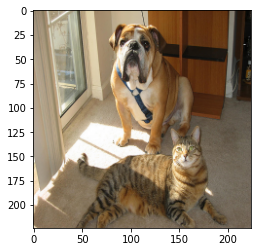

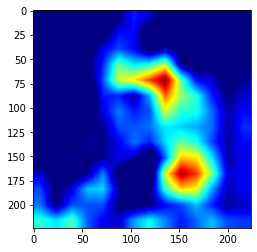

('n02110958', 'pug', 0.6312209)


In [41]:
def grad_cam(model, image, target_layer_name):
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    model_input = image_array[tf.newaxis, ...]
    gradient_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(target_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        convolution_outputs, predictions = gradient_model(model_input)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_scores = predictions[:, predicted_class_index]
    gradients = tape.gradient(predicted_class_scores, convolution_outputs)[0]
    gate_f = tf.cast(convolution_outputs[0] > 0, 'float32')
    gate_r = tf.cast(convolution_outputs[0] > 0, 'float32')
    guided_gradients = gate_f * gate_r * gradients
    weights = np.mean(guided_gradients, axis=(0, 1))
    cam = np.dot(convolution_outputs[0], weights)
    cam = cv2.resize(cam, image.size, cv2.INTER_LINEAR)
    cam  = np.maximum(cam, 0)
    heatmap = cam / cam.max()
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(image_array/255)
    plt.show()
    plt.figure()
    plt.imshow(rgb_cam)
    plt.show()
    result = tf.keras.applications.vgg16.decode_predictions(predictions.numpy(), top=1)[0][0]
    print(result)
    
pretrained_vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
# pretrained_vgg_model.summary()
model_input_shape = [224, 224, 3]
image_path = './sample-images/dog.png'
image = tf.keras.preprocessing.image.load_img(
    image_path, target_size=model_input_shape[:2]
)
target_layer_name = 'block5_conv3'
grad_cam(
    model=pretrained_vgg_model,
    image=image,
    target_layer_name=target_layer_name
)